# Clustering Analysis -  Hierarchical Clustering
The only parameter s to consider is the **similarity function** and the **merging strategy** to form the hierarchy. The merging strategy here involves to compute the proximity matrix: the strategy must be able to merge cloud of points (*inside the two given cluster*),
determining the criteria for which those two cluster are closer or farest from each other. 


#### Task
1. Choose one state in the dataset and compare different clustering results got by using different version of
the algorithm
2. We can explore if some regions or states have similar incidents characteristics.

In [192]:
# This will take a while
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import plotly.offline as py

# for dataset visibility
pd.set_option('display.max_columns', None)

# Set a seed for reproducibility
np.random.seed(42)


In [193]:
df_merged_clustering = pd.read_hdf('../ds/cleaned/reduced_for_clustering.h5')
df_merged = pd.read_csv('../ds/cleaned/merged.csv')

In [194]:
df_merged_clustering.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 131618 entries, 0 to 134578
Data columns (total 26 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   date                       131618 non-null  datetime64[ns]
 1   state                      131618 non-null  object        
 2   city_or_county             131618 non-null  object        
 3   latitude                   131618 non-null  float64       
 4   longitude                  131618 non-null  float64       
 5   congressional_district     131618 non-null  int64         
 6   participant_age_group1     131618 non-null  category      
 7   participant_gender1        131618 non-null  category      
 8   min_age_participants       131618 non-null  int64         
 9   n_participants_child       131618 non-null  int64         
 10  n_participants_teen        131618 non-null  int64         
 11  n_females                  131618 non-null  int64   

In [240]:
cols_for_clustering =[  'unharmed_ratio', 
                        'percentage_injured', 
                        'congressional_district',
                        'povertyPercentage',
                        'density_incident_state',
                        'males_to_females_ratio',
                        'candidatevotes',
                        'congressional_district',
                        'n_females',
                        'n_killed',
                        'n_injured',
                        'n_arrested'


                     ]


Pre-processing

In [241]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


We restrict to the state of `Illinois` as the city of `Chicago` is the most violent in our dataset.

In [242]:
df_ill = df_merged_clustering[df_merged_clustering['state']=='California']
df_ill_clustering = df_ill[cols_for_clustering]

In [243]:
scaler = StandardScaler()
df_ill_scaled = scaler.fit_transform(df_ill_clustering)

In [244]:
# Plot distance matrix
#sn.heatmap(squareform(pdist(df_ill_scaled, metric='euclidean')))

In [245]:
#pca
pca = PCA(n_components=2)
df_ill_pca = pca.fit_transform(df_ill_scaled)


In [246]:
"""
# Select only numeric columns for scaling
numeric_columns = df_merged_clustering.select_dtypes(include=['float64', 'int64']).columns

# Filter the DataFrame to keep only numeric columns
df_numeric = df_merged_clustering[numeric_columns]

# Scale the numeric columns
scaler = MinMaxScaler()
X = scaler.fit_transform(df_numeric.values)
"""

"\n# Select only numeric columns for scaling\nnumeric_columns = df_merged_clustering.select_dtypes(include=['float64', 'int64']).columns\n\n# Filter the DataFrame to keep only numeric columns\ndf_numeric = df_merged_clustering[numeric_columns]\n\n# Scale the numeric columns\nscaler = MinMaxScaler()\nX = scaler.fit_transform(df_numeric.values)\n"

# Hierachical Clustering
There are 2 kinds of hierarchical clustering: agglomerative and divisive. 
In the following, there are some example of the agglomerative clustering using scipy. The scipy library allows for hierachical clusters by exploiting the linkage function and then the dendrogram. 

The first function, given a matrix of pair-wise distances, computes the agglomerative clustering. There are 2 parameters: the method, that can be `single, complete, ward, average, weighted, centroids` and `median`, and the metric used to compute the distances, such as `euclidean` or `cosine`. Then, with the dendrogram function, it is possible to visualize the result obtained. This kind of clustering is also possible with scikit-learn library, but the dendrogram visualization is not directly available.

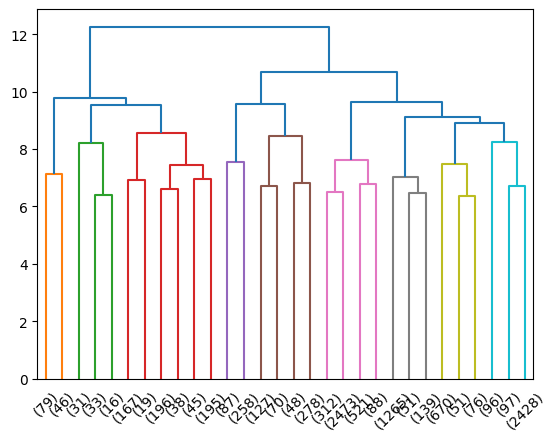

In [247]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist

import numpy as np

# Assuming X is your large dataset
# Randomly select a subset of rows (e.g., 10,000 rows)
subset_size = 10000
random_indices = np.random.choice(df_ill_scaled.shape[0], subset_size, replace=True)
subset_data = df_ill_scaled[random_indices]

# Compute pairwise distances and perform clustering on the subset
data_dist = pdist(subset_data, metric='euclidean')
data_link = linkage(data_dist, method='complete', metric='euclidean')
res = dendrogram(data_link, truncate_mode='lastp')




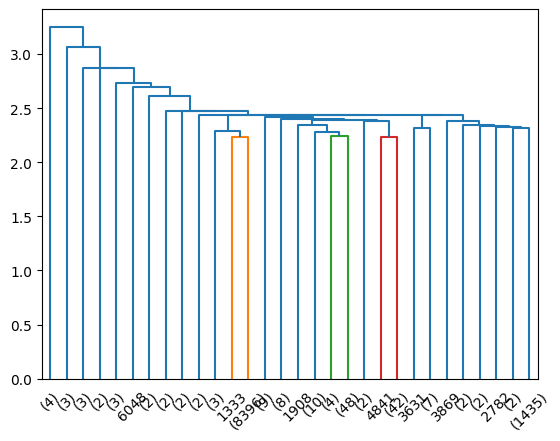

In [248]:
data_dist = pdist(subset_data, metric='euclidean')
data_link = linkage(data_dist, method='single', metric='euclidean')
res = dendrogram(data_link, truncate_mode='lastp')

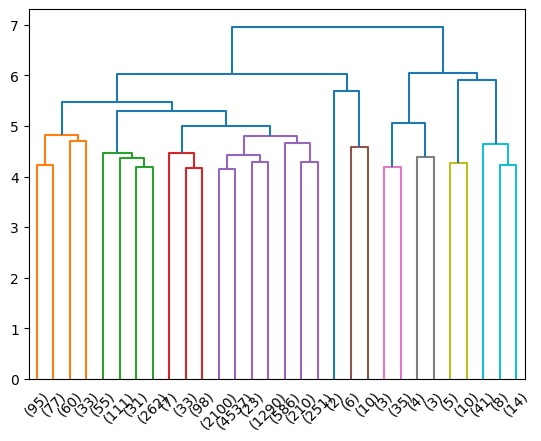

In [249]:
data_dist = pdist(subset_data, metric='euclidean')
data_link = linkage(data_dist, method='average', metric='euclidean')
res = dendrogram(data_link, truncate_mode='lastp')

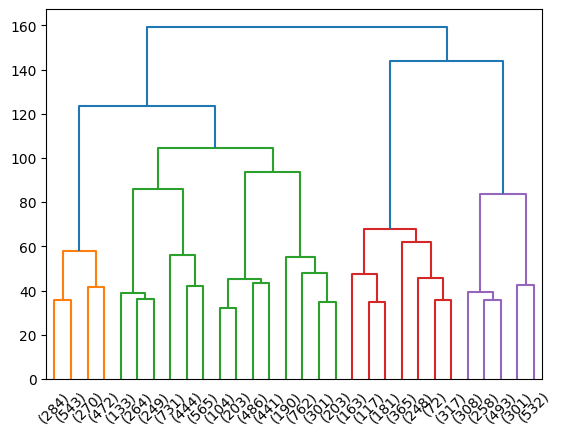

In [250]:
data_dist = pdist(subset_data, metric='euclidean')
data_link = linkage(data_dist, method='ward', metric='euclidean')
res = dendrogram(data_link, truncate_mode='lastp')

In [281]:
#with sciki-learn you have to select the number of clusters you want
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=4, metric='euclidean', linkage='ward')
cluster.fit_predict(df_ill_scaled)
print(df_ill_pca.shape)

(8384, 2)


In [282]:
df_ill['cluster_agg_ward'] = cluster.labels_
df_ill['cluster_agg_ward'].value_counts()

1    3129
0    2699
3    1348
2    1208
Name: cluster_agg_ward, dtype: int64

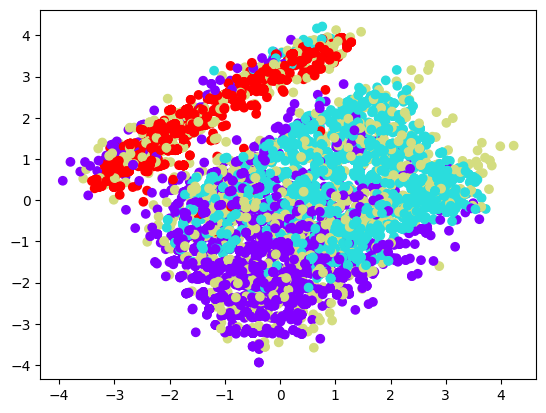

In [283]:
plt.scatter(df_ill_pca[:,1],df_ill_pca[:,0], c=df_ill['cluster_agg_ward'], cmap='rainbow')

## [WIP] Other hierarchical approaches

In [284]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster, cut_tree

pd.set_option('mode.chained_assignment', None)

In [285]:
def plot(ax, folder="clustering_hierarchical", filename="", figsize=(6.4, 4.8)):
    fig = plt.gcf()
    fig.set_size_inches(*figsize)
    plt.tight_layout()
    if filename:
        if not os.path.exists(folder):
            os.mkdir(folder)
        plt.savefig(os.path.join(folder, filename))
    plt.show()
    plt.close()

In [286]:
df_merged_clustering2 = pd.read_hdf('../ds/cleaned/reduced_for_clustering.h5')

df_ill = df_merged_clustering2[df_merged_clustering2['state']=='California']
df_ill_clustering2 = df_ill[cols_for_clustering]

In [287]:
# Normalize values
scaler = MinMaxScaler()
X = scaler.fit_transform(df_ill_clustering2.values)

In [288]:
def cluster_scatter_3d(view_init=None, label=None, filename=""):
    # 3D Scatter plot of the attributes clusterized
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    c1, c2 = cols_for_clustering[0:2]
    c3 = cols_for_clustering[3]
    scatter = ax.scatter3D(df_ill_clustering2[c1], df_ill_clustering2[c2], df_ill_clustering2[c3], c=label, label=label, s=20)
    ax.set_xlabel(c1)
    ax.set_ylabel(c2)
    ax.set_zlabel(c3)

    legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
    ax.add_artist(legend1)

    if view_init:
        ax.view_init(*view_init)
    print("Labels are:", c1, c2, c3)
    plot(None, figsize=(6,6), filename=filename)

def hierarchical_analysis(data_dist, method, metric, height=None):
    """Try hierarchical clustering with provided method and metric,
    eventually performing a tree cut. At the end, only a 3D scatter plot is visualized.
    """ 
    data_link = linkage(data_dist, method=method, metric=metric)
    plot(dendrogram(data_link, truncate_mode='lastp'), filename=f"{method}_{metric}")
    df_merged_clustering2_labels = cut_tree(data_link, height=height)
    cluster_scatter_3d(label=df_merged_clustering2_labels, filename=f'{method}_{metric}_Scatter3D')

def analysis(X, metric='euclidean'):
    """Perform clustering analysis with different methods, but same metric.
    """
    data_dist = pdist(X, metric=metric)

    # Nearest Point Algorithm - MIN
    hierarchical_analysis(data_dist, method='single', metric=metric, height=24)

    # Voor Hees Algorithm - MAX
    hierarchical_analysis(data_dist, method='complete', metric=metric, height=100)

    # UPGMA Algorithm - Group Average
    hierarchical_analysis(data_dist, method='average', metric=metric, height=24)

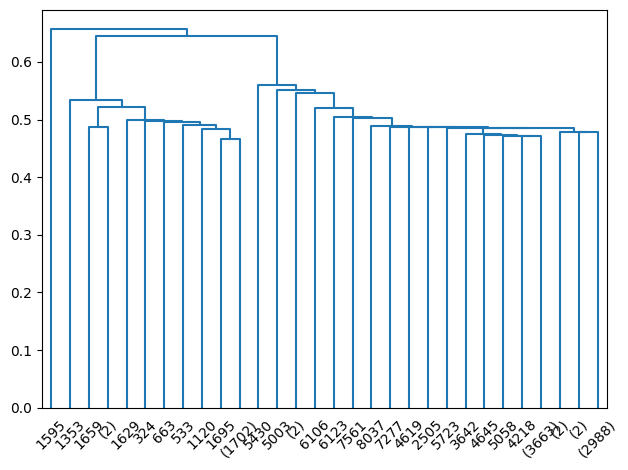

Labels are: unharmed_ratio percentage_injured povertyPercentage


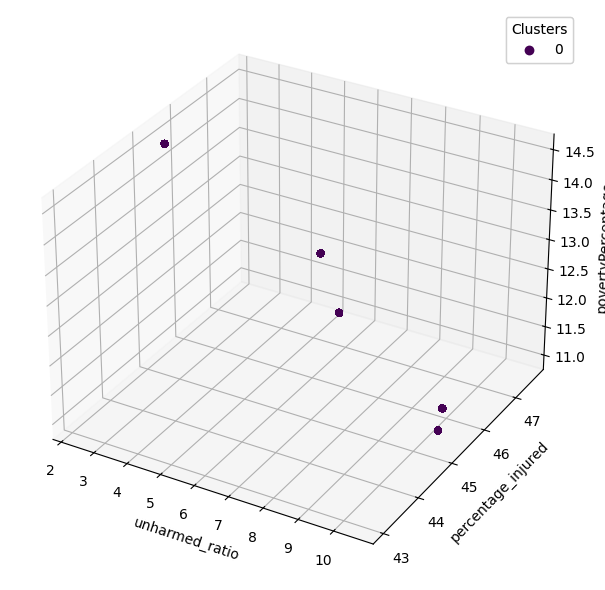

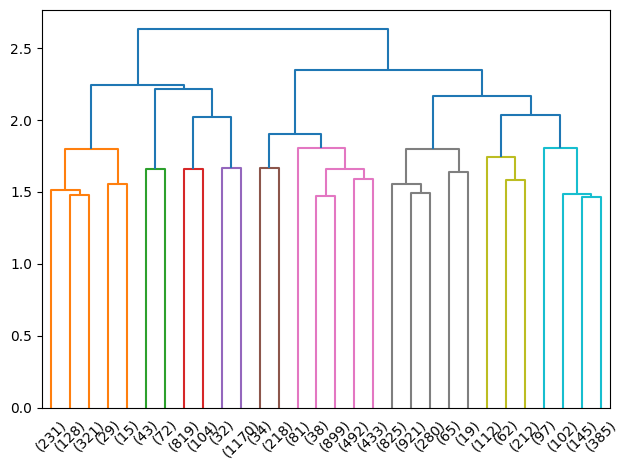

Labels are: unharmed_ratio percentage_injured povertyPercentage


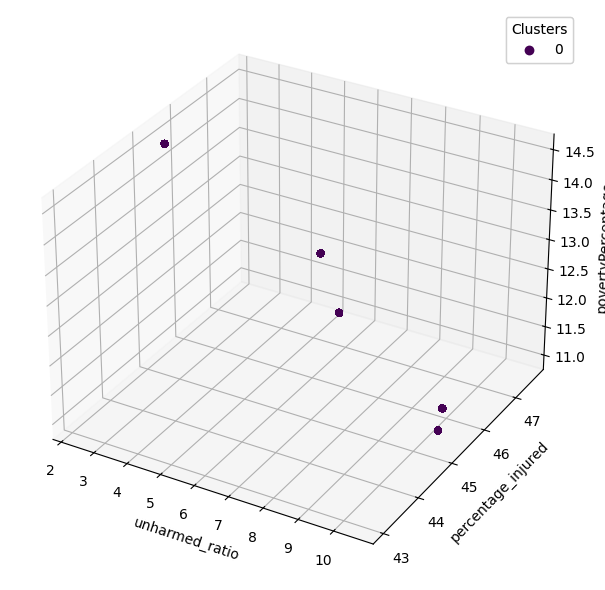

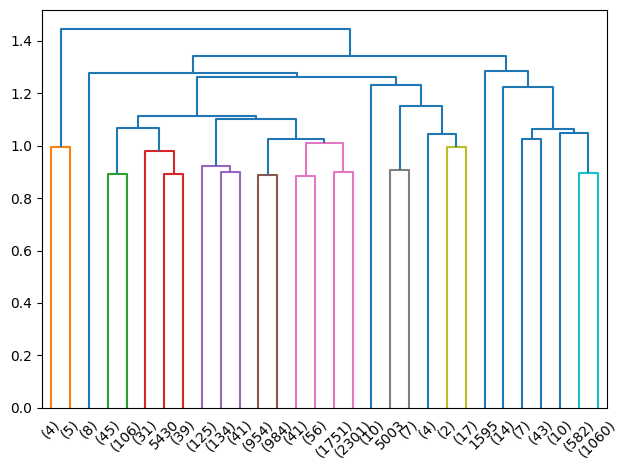

Labels are: unharmed_ratio percentage_injured povertyPercentage


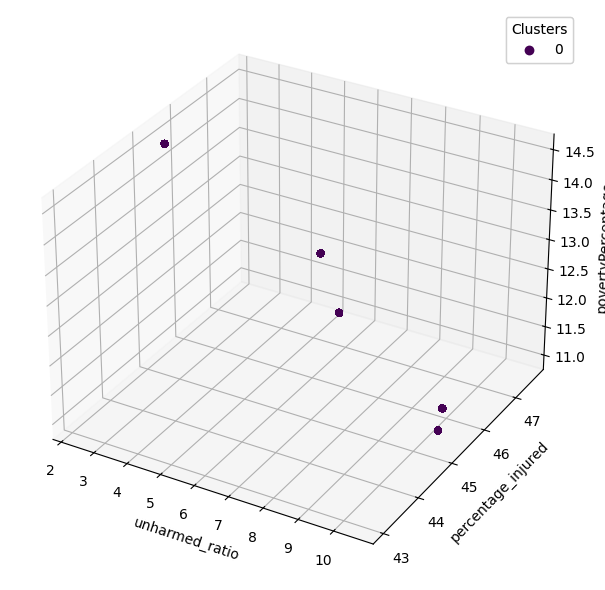

In [289]:
# Try all the methods using euclidean distance
analysis(X, metric='euclidean')

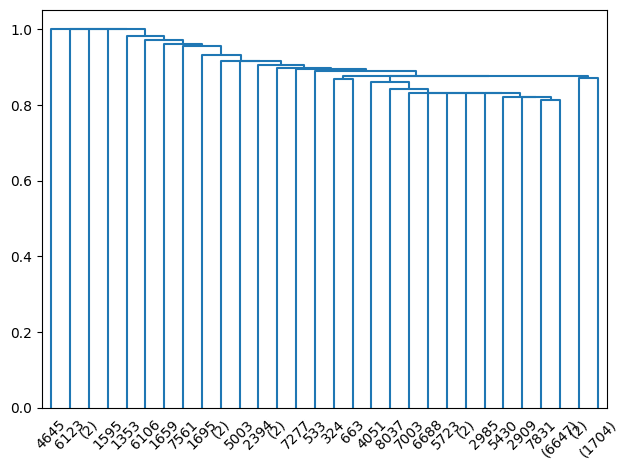

Labels are: unharmed_ratio percentage_injured povertyPercentage


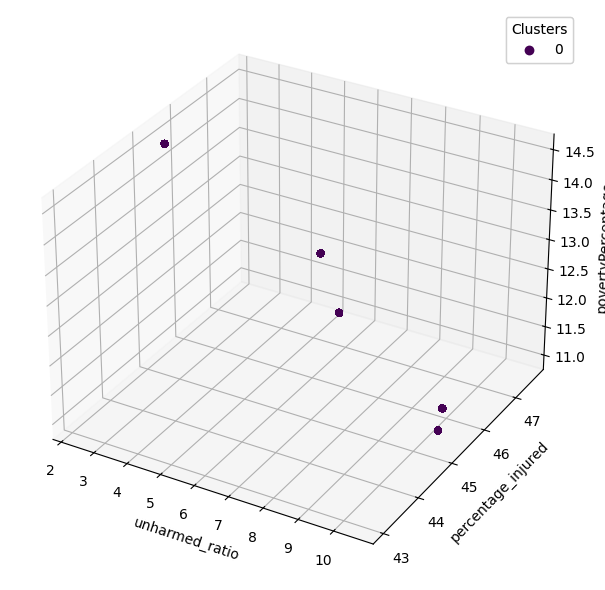

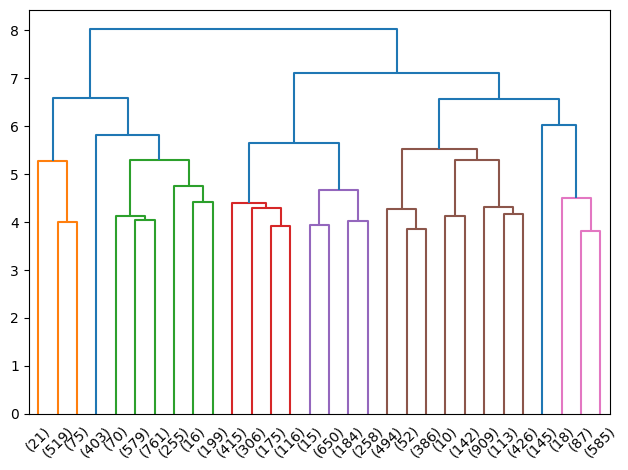

Labels are: unharmed_ratio percentage_injured povertyPercentage


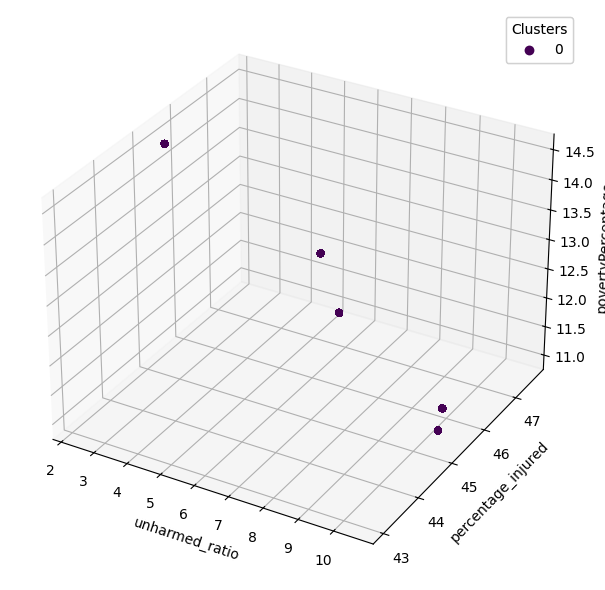

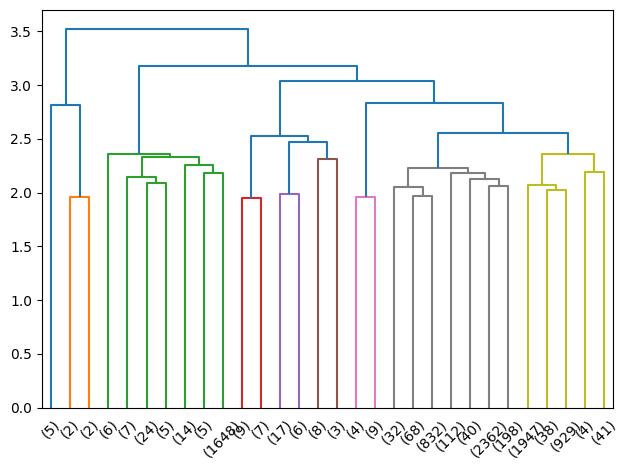

Labels are: unharmed_ratio percentage_injured povertyPercentage


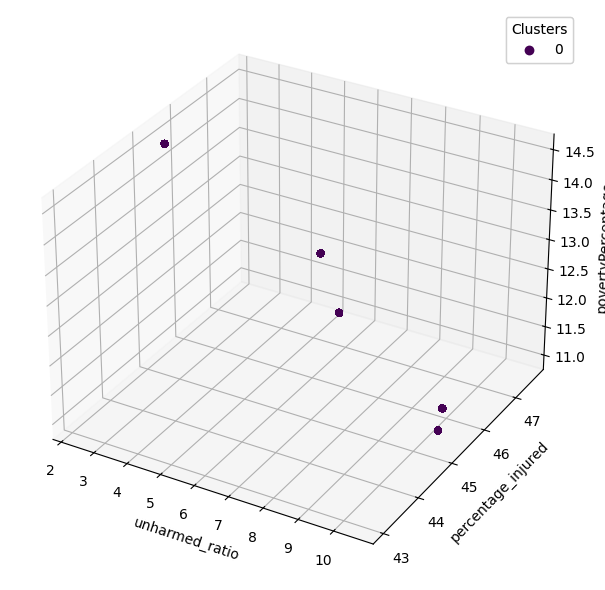

In [290]:
# Try all the methods using manhattan distance
analysis(X, metric='cityblock')


In [291]:
def last_iterations(metric='cityblock', method='complete', hs=[]):
    """Perform hierarchical analysis using tree cuts to check how the hieararchy is built.
    """
    data_dist = pdist(X, metric=metric)
    data_link = linkage(data_dist, method=method, metric=metric)

    dendrogram(data_link, truncate_mode='lastp')

    for i, h in enumerate(hs):
        df_ill_clustering2['label'] = cut_tree(data_link, height=h)
        cluster_scatter_3d(label=df_ill_clustering2['label'], filename=f"Scatter3D_{i+1}")

Labels are: unharmed_ratio percentage_injured povertyPercentage


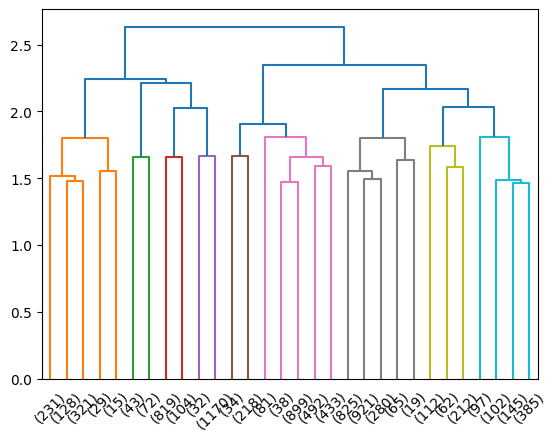

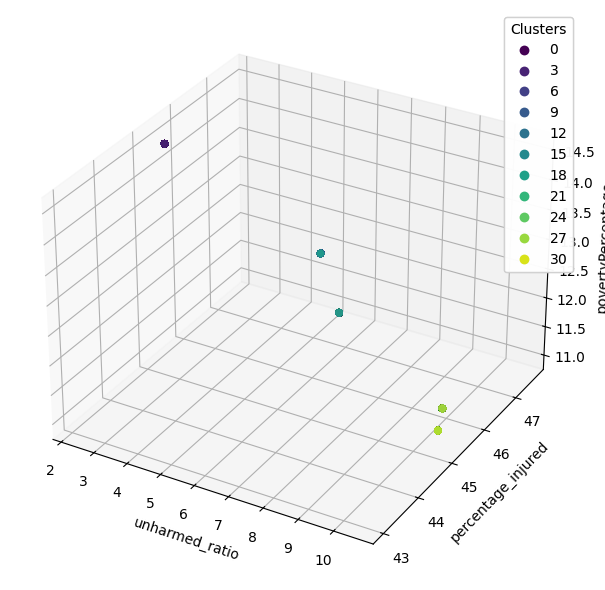

Labels are: unharmed_ratio percentage_injured povertyPercentage


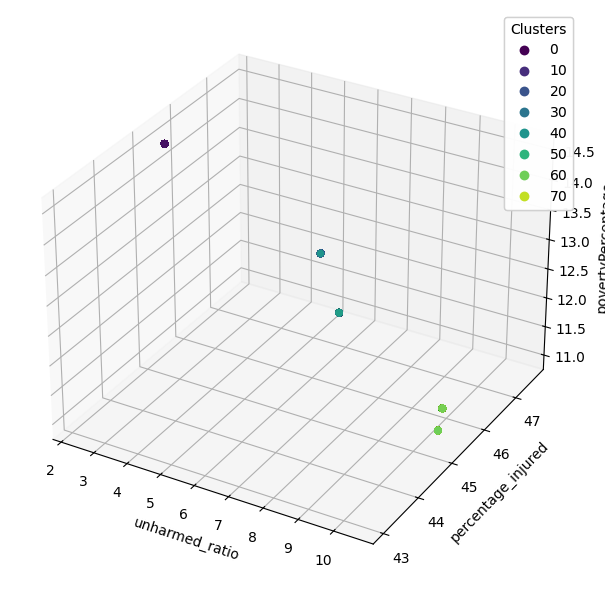

Labels are: unharmed_ratio percentage_injured povertyPercentage


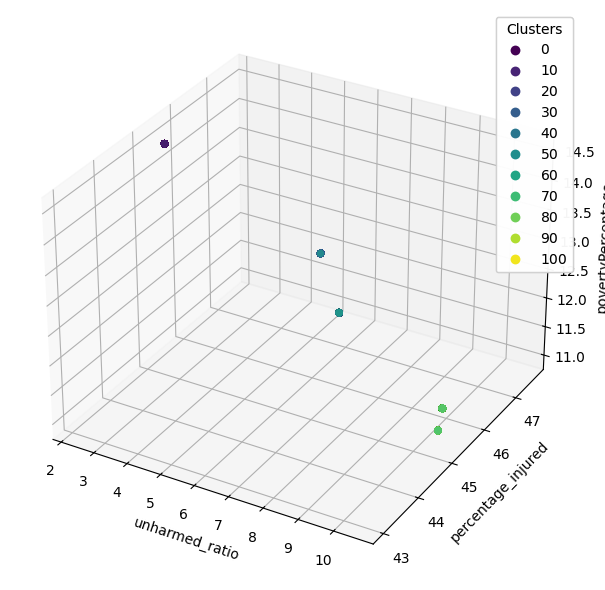

Labels are: unharmed_ratio percentage_injured povertyPercentage


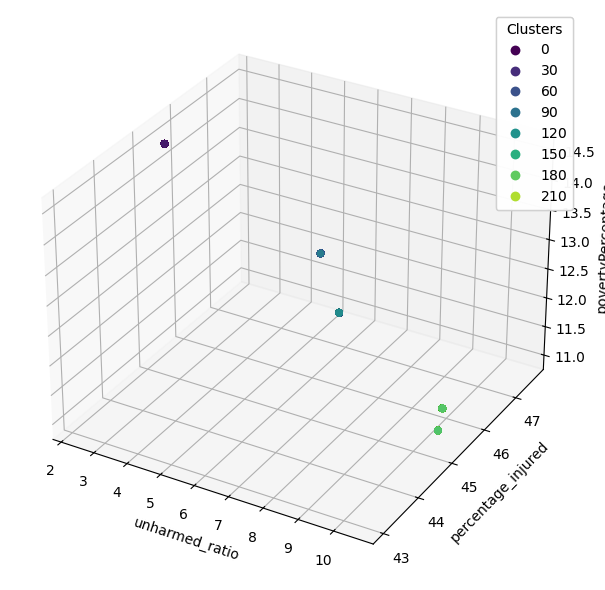

Labels are: unharmed_ratio percentage_injured povertyPercentage


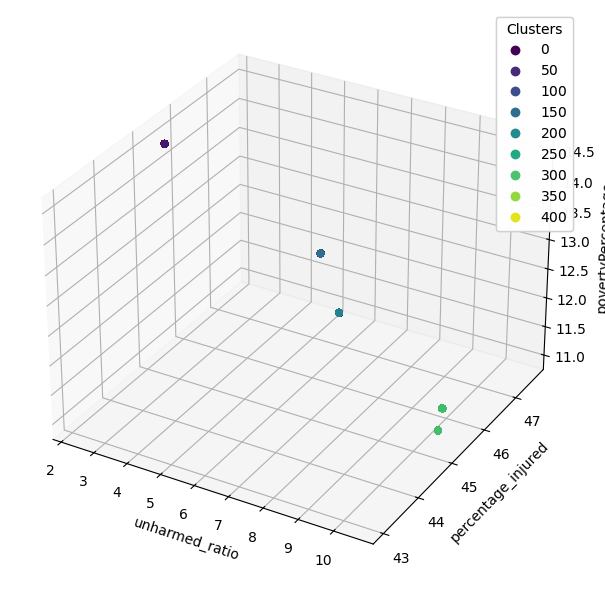

Labels are: unharmed_ratio percentage_injured povertyPercentage


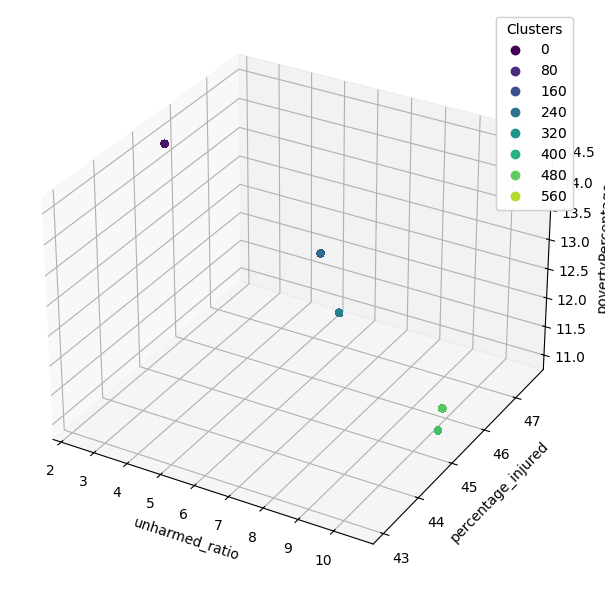

In [292]:
# Analyze hierarchies produced by euclidean-max
last_iterations(metric='euclidean', method='complete', hs=[1.4, 1.1, 1, .75, .6, .49])

Labels are: unharmed_ratio percentage_injured povertyPercentage


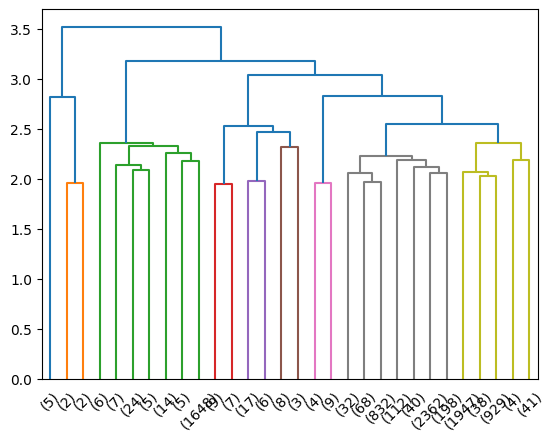

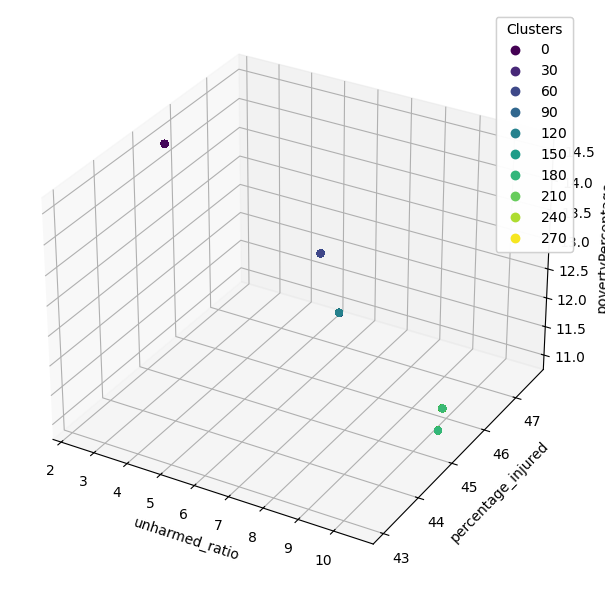

Labels are: unharmed_ratio percentage_injured povertyPercentage


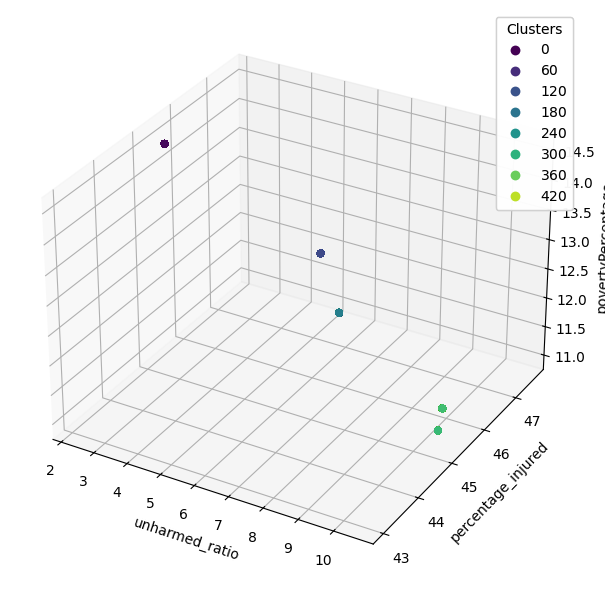

Labels are: unharmed_ratio percentage_injured povertyPercentage


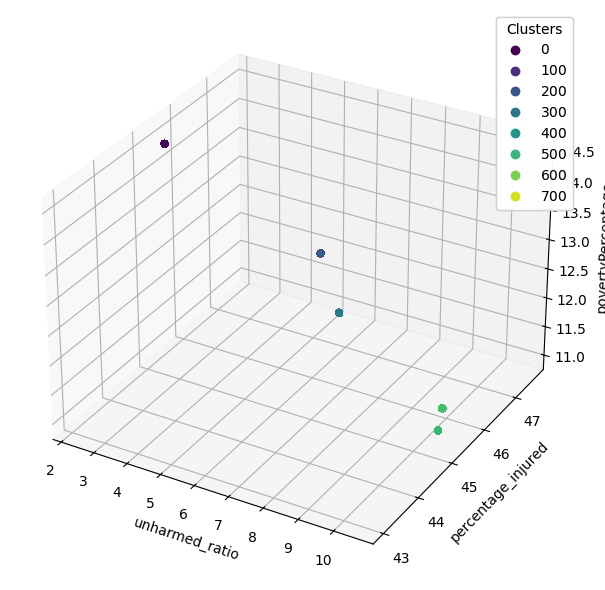

Labels are: unharmed_ratio percentage_injured povertyPercentage


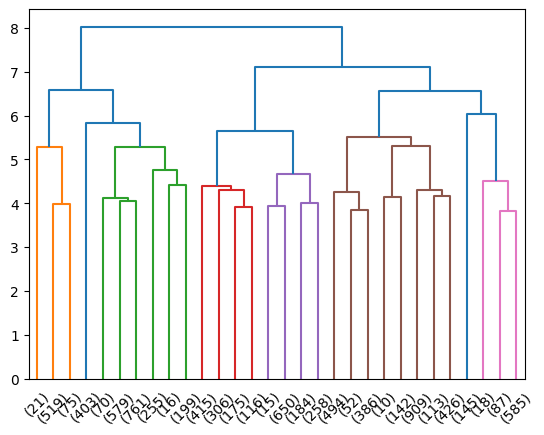

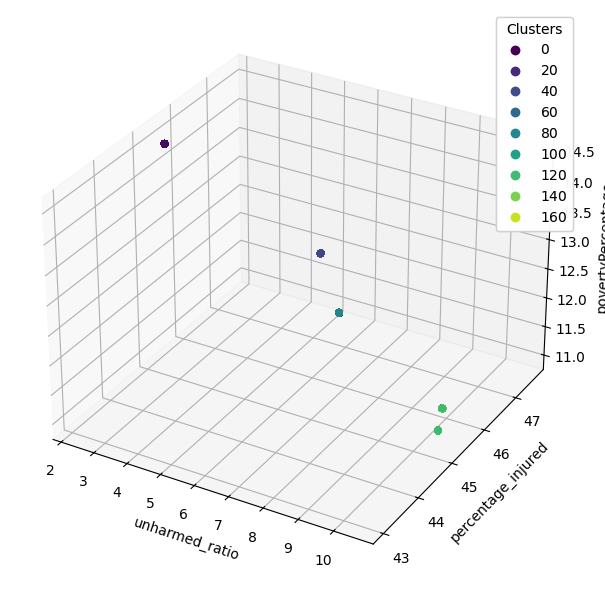

Labels are: unharmed_ratio percentage_injured povertyPercentage


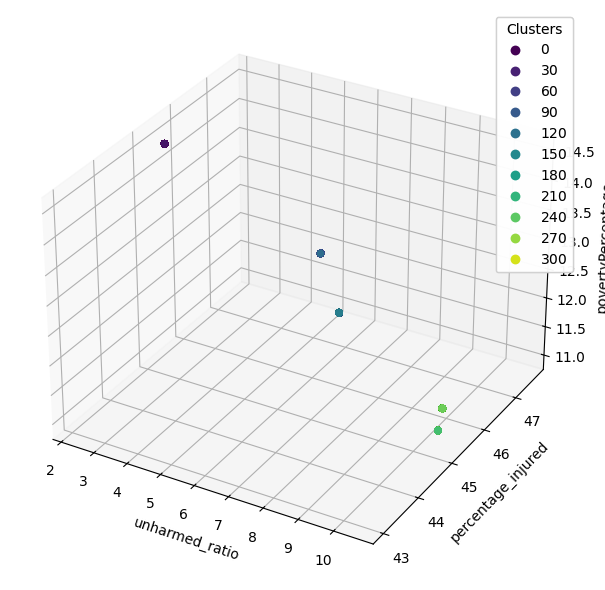

Labels are: unharmed_ratio percentage_injured povertyPercentage


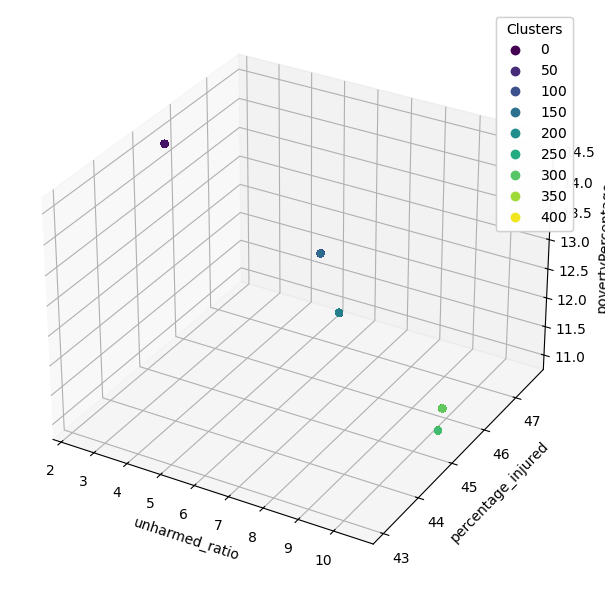

In [293]:
# Other tries
last_iterations(metric='cityblock', method='average', hs=[1, .8, .6])
last_iterations(metric='cityblock', method='complete', hs=[2, 1.5, 1.3])


In [294]:
# Compute some final scores
data_dist = pdist(X, metric='euclidean')
data_link = linkage(data_dist, method='complete', metric='euclidean')
labels = cut_tree(data_link, height=.6)

sil = round(silhouette_score(X, labels), 2)
db = round(davies_bouldin_score(X, labels), 2)
print("Silhouette:", sil)
print("Davies Bouldin:", db)

/home/luca/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Silhouette: 0.28
Davies Bouldin: 1.12


/home/luca/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

